In [1]:
username = "Alex"
pathtorepo = "C:\\Users\\" *username *  "\\Desktop\\"
using Pkg
Pkg.activate(pathtorepo * "dynamical-systems\\env\\integrate\\")

  Activating project at `C:\Users\Alex\Desktop\dynamical-systems\env\integrate`

In [2]:
using StaticArrays, DifferentialEquations, DynamicalSystems
using CairoMakie, GLMakie

In [3]:
function tetrapart_model(var, par, t)

    E, x, u, y, ecm, p  = var;
    τ, τD, τF, τy, α, αE, αecm, αp, J, U0, I0, ΔU0, β, βecm, βp, γp, ecm0, ecm1, kecm, θecm, p0, p1, θp, kp, ythr, xthr = par;

    g = log( 1 + exp( ( (J + αE * ecm) * u * x * E + I0) / α ) );
    U = U0 + ΔU0 / ( 1 + exp( -50 * ( y - ythr ) ) );
    Hy = 1 / ( 1 + exp( -20 * ( x - xthr ) ) );
    Hecm = ecm0 - (ecm0 - ecm1) / (1 + exp( -(E - θecm) / kecm ) );
    Hp =  p0 - (p0 - p1) / (1 + exp( -(E - θp) / kp) );

    dE = (-E + α * g) / τ;
    dx = (1 - x) / τD  -u * x * E;
    du = (U - u) / τF  + U * (1 - u) * E;
    dy = (-y) / τy + β * Hy;
    decm = -( αecm + γp * p ) * ecm + βecm * Hecm;
    dp = -αp * p + βp * Hp;

    return SVector(dE, dx, du, dy, decm, dp);
end

tetrapart_model (generic function with 1 method)

In [72]:
time = 5000.0; tt = 0.0; tstep = 0.001; times = [time, tt]
integ_set = (alg = Vern9(), adaptive = false, dt = tstep);

In [73]:
# αE = 5.0;
multistab = [2.422092651924434, 0.8446031114662503, 0.6534291088738378, 0.09540062161211987, 0.0004056327238809937, 1.4805608752412292e-9];

In [74]:
τ = 0.013; τD = 0.15; τF = 1.0; τy = 1.8;   
α = 1.5; αecm = 0.001; αp = 0.01;
J = 3.07; U0 = 0.3; I0 = -1.72; ΔU0 = 0.305;
β = 0.438; βp = 0.01; βecm = 0.01; βp = 0.01;
ecm0 = 0.0; ecm1 = 1.0; kecm = 0.15; θecm = 25.6;
p0 = 0.0; p1 = 1.0; kp = 0.05; γp = 0.1; θp = 26.0; 
ythr = 0.5; xthr = 0.9;

In [75]:
u01 = multistab;
u02 = zeros(6);

In [125]:
# control parameter
αE =  1.856;
params = [τ, τD, τF, τy, α, αE, αecm, αp, J, U0, I0, ΔU0, β, βecm, βp, γp, ecm0, ecm1, kecm, θecm, p0, p1, θp, kp, ythr, xthr];
ds = CoupledODEs(tetrapart_model, u02, params, diffeq = integ_set);
tr, trange = trajectory(ds, time, Δt = tstep);

ds1 = CoupledODEs(tetrapart_model, u01, params, diffeq = integ_set);
tr1, trange1 = trajectory(ds1, time, Δt = tstep);

In [9]:
#@show varinfo()
;

In [31]:
"""tstart, tend = 1, 4000000 # 2500000, 2700000
tickssize = 15
labelsize = 20
indexvar = 4
CairoMakie.activate!()

f= Figure(resolution = (1400, 300))
axisrHz  = Axis(f[1, 1], xlabel = L"time", ylabel = L"ECM, p",
xlabelsize = labelsize, ylabelsize = labelsize,
xticklabelsize = tickssize, yticklabelsize = tickssize,
xgridvisible = false, ygridvisible = false)
lines!(axisrHz, trange[tstart:tend], tr[tstart:tend, 5], linewidth = 1.0, color = :blue)
lines!(axisrHz, trange[tstart:tend], tr[tstart:tend, 6], linewidth = 1.0, color = :orange)
display(f)"""
;

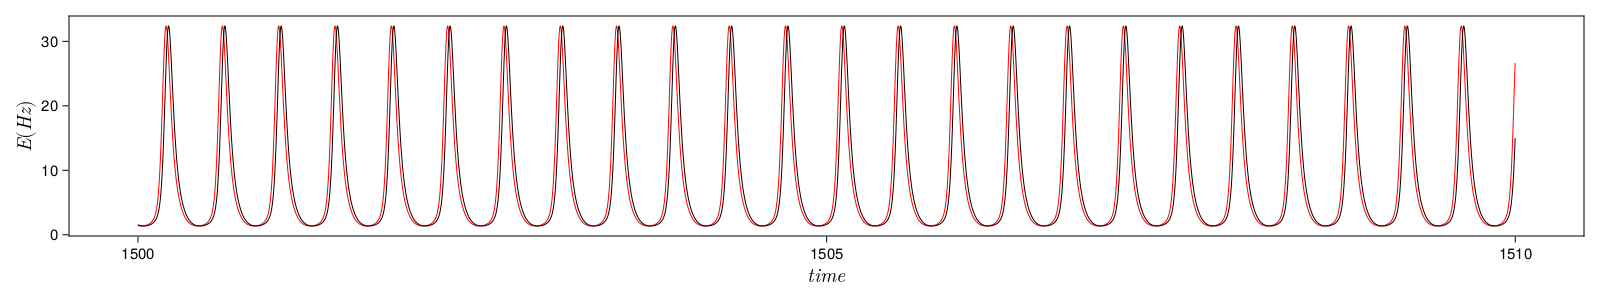

CairoMakie.Screen{IMAGE}


In [126]:
tstart, tend = 1500000, 1510000 # 2500000, 2700000
tickssize = 15
labelsize = 20
indexvar = 1
CairoMakie.activate!()

f= Figure(resolution = (1600, 300))
axisrHz  = Axis(f[1, 1], xlabel = L"time", ylabel = L"E(Hz)",
xlabelsize = labelsize, ylabelsize = labelsize,
xticklabelsize = tickssize, yticklabelsize = tickssize,
xgridvisible = false, ygridvisible = false)

lines!(axisrHz, trange1[tstart:tend], tr1[tstart:tend, indexvar], linewidth = 1.0, color = :red)
lines!(axisrHz, trange[tstart:tend], tr[tstart:tend, indexvar], linewidth = 1.0, color = :black)

display(f)

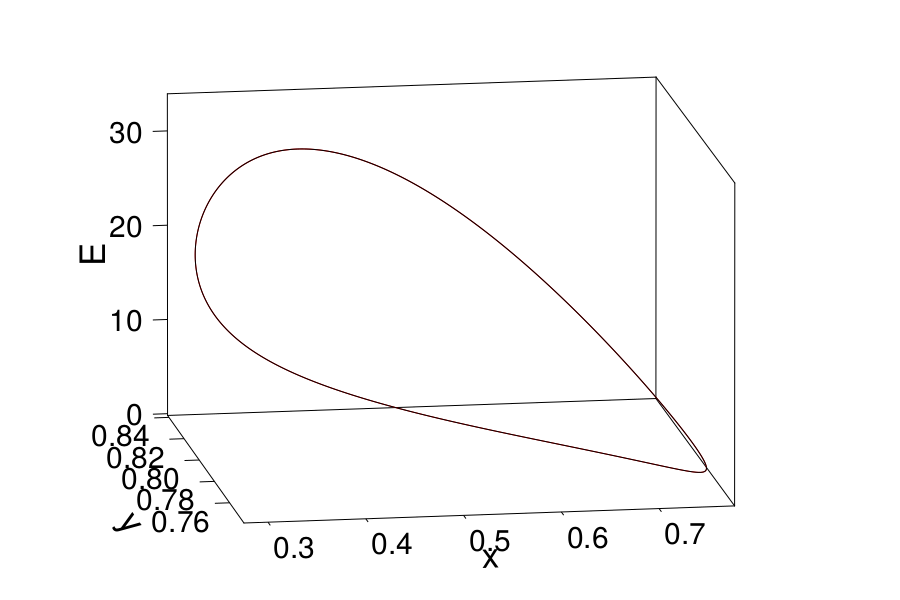

CairoMakie.Screen{IMAGE}


In [127]:
ts, tf = 1500000, 1510000 #2500000, 2900000
ts1, tf1 = 1000000, 4000000
idx, idy, idz = 2, 3, 1
lb_size = 35; tck_size = 30;
prot = 60;
disx  = 20;
disy = 70;
disz = 55;

CairoMakie.activate!()
f = Figure(resolution = (900, 600))
ax = Axis3(f[1, 1], azimuth = -0.55pi, elevation = 0.07pi,
            xlabel = "x", ylabel = "y", zlabel = "E",
            xlabelsize = lb_size, ylabelsize = lb_size, zlabelsize = lb_size,
            xticklabelsize = tck_size, yticklabelsize = tck_size, zticklabelsize = tck_size,
            xgridvisible = false, ygridvisible = false, zgridvisible = false,
            protrusions = prot, xlabeloffset = disx, ylabeloffset = disy, zlabeloffset = disz)

#ax = LScene(f[1, 1])
#scale!(ax.scene, 1, 50, 50)

lines!(tr1[ts1:tf1, idx], tr1[ts1:tf1, idy], tr1[ts1:tf1, idz], linewidth = 1.0, color = :red)
lines!(tr[ts:tf, idx], tr[ts:tf, idy], tr[ts:tf, idz], linewidth = 1.0, color = :black)

display(f)

In [110]:
"""ts, tf = 100000, 200000

idx, idy, idz = 2, 3, 1
lb_size = 35; tck_size = 30;
dis  = 60;

GLMakie.activate!()
f = Figure(resolution = (600, 600))
ax = LScene(f[1, 1])
scale!(ax.scene, 50, 50, 1)

lines!(tr1[ts:tf, idx], tr1[ts:tf, idy], tr1[ts:tf, idz], linewidth = 1.0, color = :red)
lines!(tr[ts:tf, idx], tr[ts:tf, idy], tr[ts:tf, idz], linewidth = 1.0, color = :black)

display(GLMakie.Screen(), f)"""
;